In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install scikit-plot
!pip install tf-keras-vis tensorflow


In [3]:
# import all libraries
# Train/Test Libraries
import os
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import roc_curve, auc

# Visualization Libraries
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from matplotlib import cm

%cd '/content/drive/My Drive/GitHub Repositories/Tuberculosis/Classification'

/content/drive/My Drive/GitHub Repositories/Tuberculosis/Classification


In [4]:
IMG_SIZE = 224

train_x = np.load('./data/Numpy Files/train_images.npy')
train_y = np.load('./data/Numpy Files/train_labels.npy')
test_x = np.load('./data/Numpy Files/valid_images.npy')
test_y = np.load('./data/Numpy Files/valid_labels.npy')

print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255.0
test_x/=255.0

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))


Training Images: (600, 224, 224, 3) | Test Images: (200, 224, 224, 3)
Training Labels: (600,) | Test Labels: (200,)
Train: 0.0 , 255.0 | Test: 0.0 , 255.0
Train: 0.0 , 1.0 | Test: 0.0 , 1.0


In [5]:
# Class Mapping 
print('0:Healthy | 1:Tuberculosis')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

# Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=2) 
test_y_oneHot = tf.one_hot(test_y, depth=2)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))


0:Healthy | 1:Tuberculosis
Counter({0: 304, 1: 296})
Counter({0: 102, 1: 98})
Training Labels: (600, 2) | Test Labels: (200, 2)


In [9]:
# initialize the training data augmentation object
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=False,
                                                          samplewise_std_normalization=False,
                                                          horizontal_flip = True,
                                                          vertical_flip = False,
                                                          height_shift_range = 0.15,
                                                          width_shift_range = 0.15,
                                                          rotation_range = 15,
                                                          shear_range = 0.01,
                                                          fill_mode = 'nearest',
                                                          zoom_range=0.2
                                                          )
def TuberculosisModel():
  inputs= tf.keras.layers.Input(shape=(224, 224, 3))
  
  outputs = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(inputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)
  outputs = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(outputs)

  outputs = tf.keras.layers.Conv2D(32, (3, 3))(outputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)
  outputs = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(outputs)

  outputs = tf.keras.layers.Conv2D(64, (3, 3))(outputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)
  outputs = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(outputs)

  outputs = tf.keras.layers.Conv2D(128, (3, 3))(outputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)

  outputs = tf.keras.layers.Conv2D(256, (3, 3))(outputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)

  outputs = tf.keras.layers.Conv2D(128, (3, 3))(outputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)
  outputs = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(outputs)

  outputs = tf.keras.layers.Conv2D(64, (3, 3))(outputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)
  outputs = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(outputs)

  outputs = tf.keras.layers.Conv2D(32, (3, 3))(outputs)
  outputs = tf.keras.layers.Activation("relu")(outputs)
  outputs = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(outputs)

  outputs = tf.keras.layers.Flatten()(outputs)
  outputs = tf.keras.layers.Dense(32)(outputs)
  outputs = tf.keras.layers.Dropout(0.25)(outputs)
  outputs = tf.keras.layers.Dense(2)(outputs)
  outputs = tf.keras.layers.Activation("softmax")(outputs)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

model = TuberculosisModel()
# compile our model
print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 100
BATCHSIZE = 32 
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['categorical_accuracy'])
print(model.summary())

[INFO] compiling model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_18 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 110, 110, 32)      9248      
_________________________________________________________________
activation_19 (Activation)   (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (Non

In [10]:
modelPath = './saved Models/Classification/Simple CNN'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.8, patience=10, verbose=1, mode='auto',
                                                      min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", mode="auto", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/cnn-tb-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='auto')
STEP_TRAIN = len(train_x) // BATCHSIZE

modelHistory = model.fit(trainAug.flow(train_x, train_y_oneHot, batch_size=BATCHSIZE), steps_per_epoch=STEP_TRAIN, 
                         validation_data= (test_x, test_y_oneHot), epochs=EPOCHS, verbose=1, callbacks=[model_checkpoint])

tf.keras.models.save_model(model, modelPath+'/cnn-tb-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Created
Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 0.6988 - categorical_accuracy: 0.5052
Epoch 00001: val_categorical_accuracy improved from -inf to 0.51000, saving model to ./saved Models/Classification/Simple CNN/cnn-tb-best-model.h5
18/18 [==============================] - 7s 365ms/step - loss: 0.6988 - categorical_accuracy: 0.5052 - val_loss: 0.6930 - val_categorical_accuracy: 0.5100
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 0.6947 - categorical_accuracy: 0.5053
Epoch 00002: val_categorical_accuracy did not improve from 0.51000
18/18 [==============================] - 6s 343ms/step - loss: 0.6947 - categorical_accuracy: 0.5053 - val_loss: 0.6952 - val_categorical_accuracy: 0.5100
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 0.6932 - categorical_accuracy: 0.4894
Epoch 00003: val_categorical_accuracy did not improve from 0.51000
18/18 [==============================] - 6s 347ms/step - loss: 0

In [13]:
# Evaluate the Best Saved Model
# bestModel = tf.keras.models.load_model('./saved Models/Classification/Simple CNN/cnn-tb-best-model.h5')
loss, accuracy= model.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)
print('Model Accuracy: {:0.2f} | Model Loss: {:0.4f}'.format(accuracy, loss))

7/7 [==============================] - 0s 13ms/step - loss: 0.5008 - categorical_accuracy: 0.7450
Model Accuracy: 0.75 | Model Loss: 0.5008


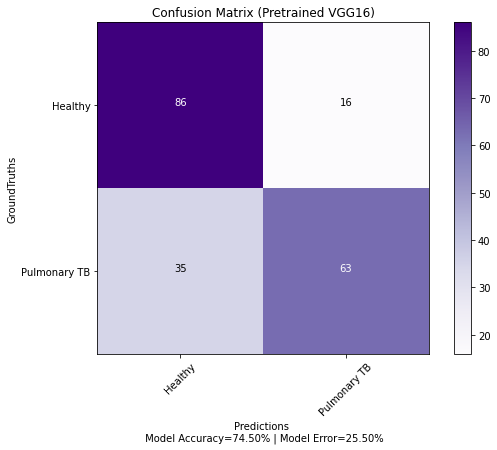

In [14]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('GroundTruths')
    plt.xlabel('Predictions \n Model Accuracy={:0.2f}% | Model Error={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.savefig('./ReadMe Images/VGG16-cm.png', bbox_inches = "tight")
    plt.show()


predictions = model.predict(x=test_x, batch_size=32)
predictions = tf.keras.backend.argmax(predictions, axis=-1)

test_y = tf.keras.backend.argmax(test_y_oneHot, axis=-1)
cm = confusion_matrix(test_y, predictions)
classes = ['Healthy', 'Pulmonary TB']
plot_confusion_matrix(cm=cm, normalize = False, target_names = classes, title= "Confusion Matrix (Pretrained VGG16)")


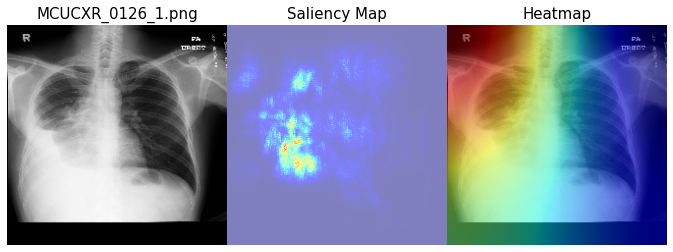

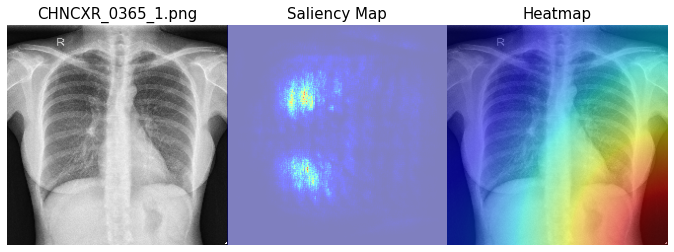

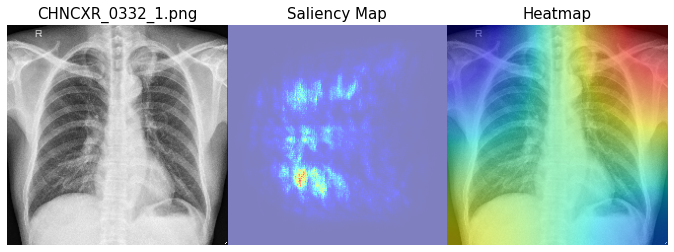

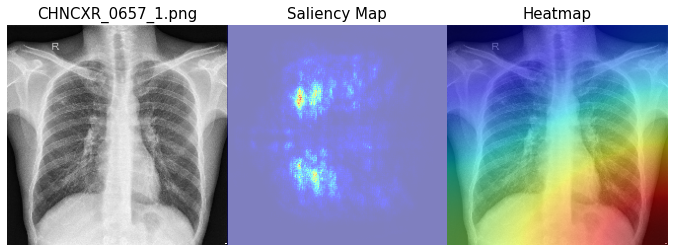

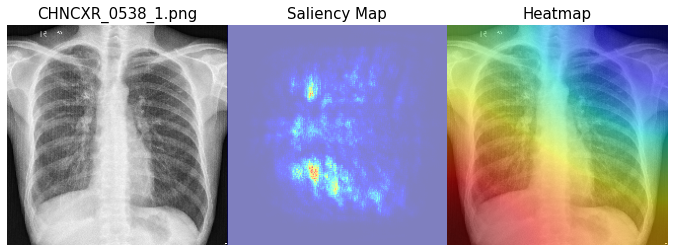

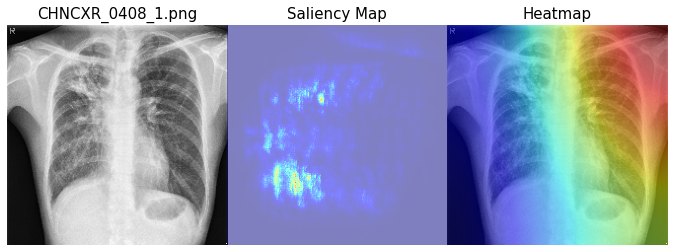

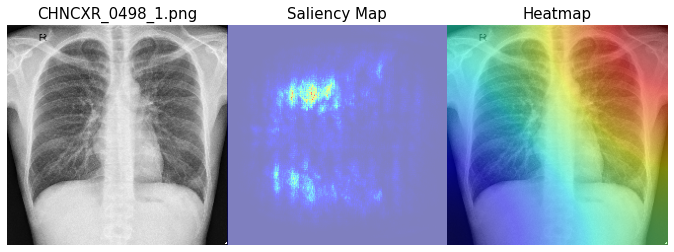

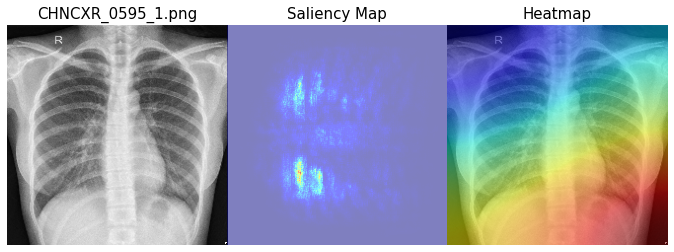

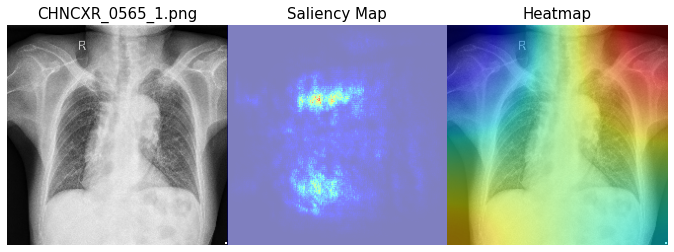

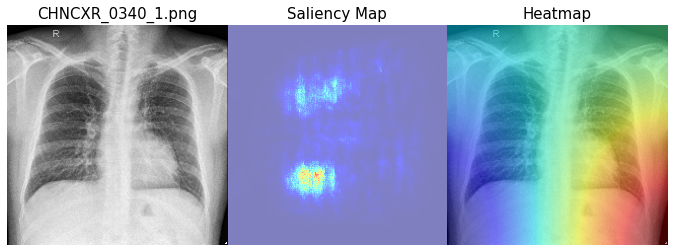

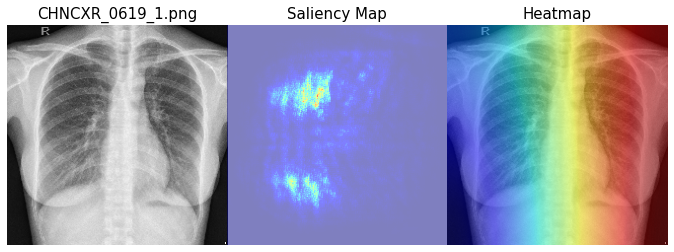

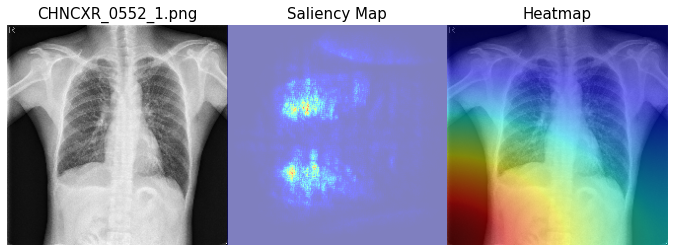

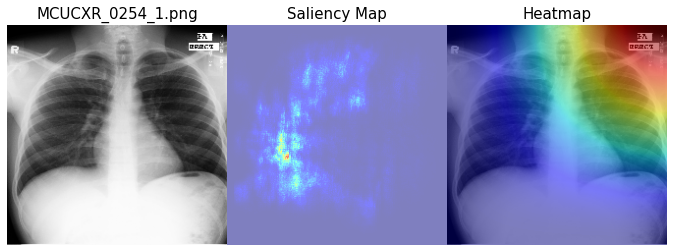

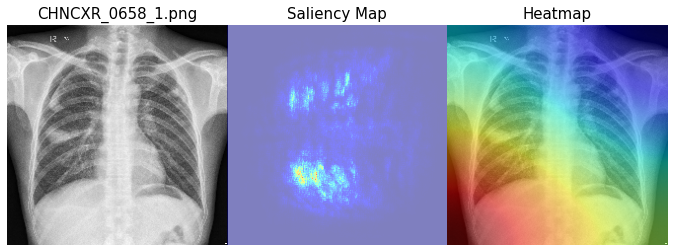

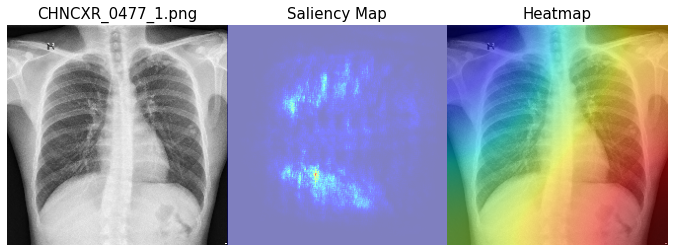

In [0]:
from matplotlib import cm
validDir =  './data/valid'
# model = tf.keras.models.load_model('./saved Models/Classification/Simple CNN/cnn-tb-best-model.h5')

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(model, model_modifier)
# Create Gradcam object
gradcam = Gradcam(model, model_modifier)

def Get_Gadcam_Map(img, loss):
  # Define loss function. cls is the output index corresponding to respective class.
  # Generate heatmap with GradCAM
  cam = gradcam(loss, img)
  cam = normalize(cam)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  heatmap = np.squeeze(heatmap)
  return heatmap

def Get_Saliency_Map(img, predictions):
  # Define loss function. cls is the output index corresponding to respective class.
  loss = lambda output: K.mean(output[:, predictions])
  # Generate saliency map
  saliency_map = saliency(loss, img, smooth_samples=20)
  saliency_map = normalize(saliency_map)
  saliency_map = np.swapaxes(saliency_map, 0, 2)
  return loss, saliency_map

imgNames = os.listdir(os.path.join(validDir, '1'))
for imgName in imgNames:
  img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(validDir, '1', imgName), target_size=(224, 224)),
                                            dtype=np.float32)
  img = (img/255.0)
  img = np.expand_dims(img, axis=0)
  predictions = model.predict(img)
  if np.argmax(predictions)==1:
    loss, saliency_map_ = Get_Saliency_Map(img, 1)
    cam_ = Get_Gadcam_Map(img, loss)

    rows = 1
    cols = 3
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(9.5, 10.5), squeeze=False)
    for r in range(rows):
      # plot image
      ax[r][0].imshow(img[0, :, :, :])
      ax[r][0].set_title(imgName, fontsize=15)
      ax[r][0].axis('off')
      
      # plot saliency
      ax[r][1].imshow(saliency_map_[:, :, 0], cmap='jet', alpha=0.5)
      ax[r][1].set_title('Saliency Map', fontsize=15)
      ax[r][1].axis('off')

      # plot heatmap
      ax[r][2].imshow(img[0, :, :, :])
      ax[r][2].imshow(cam_[:, :, :], cmap='jet', alpha=0.5)
      ax[r][2].set_title('Heatmap', fontsize=15)
      ax[r][2].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()
  



  
  
